In [21]:
import os

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

import shutil
shutil.copy("kaggle.json", os.path.join(kaggle_dir, "kaggle.json"))

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

In [22]:
import kaggle
kaggle.api.authenticate()

# Check if dataset already exists before downloading
if not os.path.exists('data') or not os.path.exists(os.path.join('data', 'HAM10000_metadata.csv')):
    kaggle.api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', path='data', unzip=True)
    print("Dataset downloaded")
else:
    print("Dataset already exists, skipping download")

Dataset already exists, skipping download


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
CSV_PATH = os.path.join("data", "HAM10000_metadata.csv")
IMAGE_DIR_PART_1 = os.path.join("data", "HAM10000_images_part_1")
IMAGE_DIR_PART_2 = os.path.join("data", "HAM10000_images_part_2")
BATCH_SIZE = 32
IMAGE_SIZE = 224
LR = 0.001
EPOCHS = 10

In [26]:
# There is multiple class in label. Let's make this Binary Classification problem by mapping to one of two classes
# 0 -> Benign
# 1 -> Malignant
CLASS_MAPPING={
    'nv': 0, 'bkl':0, 'df':0, 'vasc':0, 'mel':1, 'bcc':1, 'akiec':1
}

In [27]:
class SkinCancerDataset(Dataset):
    def __init__(self, csv_path, image_dir_part_1, image_dir_part_2, transform = None, default_image_path = None):
        self.data = pd.read_csv(csv_path)
        self.image_dir_part_1 = image_dir_part_1
        self.image_dir_part_2 = image_dir_part_2
        self.transform = transform
        self.default_image_path = default_image_path
        self.data['target'] = self.data['dx'].map(CLASS_MAPPING)

        self.data = self.data.reset_index(drop = True)

    def __len__(self):
      return len(self.data)
  
    def __getitem__(self, idx):
      # Ensure idx is integer (fixes location-based indexing error)
      if isinstance(idx, (list, tuple, np.ndarray)):
        idx = idx[0]
      if torch.is_tensor(idx):
        idx = idx.item()
  
      img_id = self.data.iloc[idx]['image_id']
      label = self.data.iloc[idx]['target']
  
      img_path_1 = os.path.join(self.image_dir_part_1, img_id + '.jpg')
      img_path_2 = os.path.join(self.image_dir_part_2, img_id + '.jpg')
  
      image = None
  
      for img_path in [img_path_1, img_path_2]:
        if os.path.exists(img_path):
          try:
            image = Image.open(img_path).convert('RGB')
            break
          except Exception as e:
            print(f'Error loading {img_path}: {str(e)}')
  
      if image is None:
        if self.default_image_path and os.path.exists(self.default_image_path):
          image = Image.open(self.default_image_path).convert('RGB')
          print(f'Using default image for missing: {img_id}')
        else:
          image = Image.new('RGB', (224, 224), (0, 0, 0))
          print(f'Created black image for missing: {img_id}')
  
      if self.transform:
        image = self.transform(image)
  
      return image, torch.tensor(label, dtype = torch.long)

In [28]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [29]:
dataset_full = SkinCancerDataset(CSV_PATH, IMAGE_DIR_PART_1, IMAGE_DIR_PART_2, transform = transform)
train_size = int(0.8 * len(dataset_full))
test_size = len(dataset_full) - train_size
train_dataset, test_dataset = random_split(dataset_full, [train_size, test_size])

In [30]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [31]:
class SkinCancerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [32]:
model = SkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)

In [33]:
def train_model():
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        # Training
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        val_loss /= len(test_dataset)
        val_losses.append(val_loss)
        val_acc = correct / len(test_dataset)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{EPOCHS} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Val Acc: {val_acc:.4f}'
        )

    # Plot losses
    plt.plot(train_losses, label = 'Training Loss')
    plt.plot(val_losses, label = 'Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

Epoch 1/10 | Train Loss: 0.4612 | Val Loss: 0.4561 | Val Acc: 0.8093
Epoch 2/10 | Train Loss: 0.4185 | Val Loss: 0.3782 | Val Acc: 0.8238
Epoch 3/10 | Train Loss: 0.3952 | Val Loss: 0.4040 | Val Acc: 0.8053
Epoch 4/10 | Train Loss: 0.3863 | Val Loss: 0.3702 | Val Acc: 0.8268
Epoch 5/10 | Train Loss: 0.3738 | Val Loss: 0.3692 | Val Acc: 0.8268
Epoch 6/10 | Train Loss: 0.3659 | Val Loss: 0.3740 | Val Acc: 0.8303
Epoch 7/10 | Train Loss: 0.3526 | Val Loss: 0.3494 | Val Acc: 0.8318
Epoch 8/10 | Train Loss: 0.3437 | Val Loss: 0.3529 | Val Acc: 0.8328
Epoch 9/10 | Train Loss: 0.3395 | Val Loss: 0.3438 | Val Acc: 0.8342
Epoch 10/10 | Train Loss: 0.3376 | Val Loss: 0.3398 | Val Acc: 0.8382


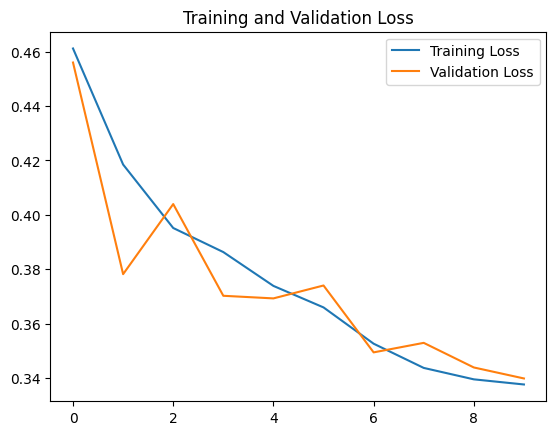

In [34]:
train_model()